One of the things that separates the men from the boys, as it were (and if you'll pardon the casual gendering), is the ability to do any sort of predictive modeling. I've learned quite a few things since "leaving" academia and attempting to become a professional data scientist, and one of them is the difference in focus between descriptive and predictive models. In psychology, my domain, descriptive models are king - we want to know how the mind and brain work, and to explain behavior in combinations of cognitive constructs (e.g. meaning and sound processing as part of language production). Outside of that domain, particularly in the insurance, finance, and social media-focused companies that populate Chicago, people are far more interested in predicting behavior, no matter its origins. They want to know whether a customer will commit fraud, or will buy again, or what they'll buy, or whether the market will move in a particular way. And although it would be nice to understand why at the same time, if the model is accurate but a black box, that's better than merely descriptive (i.e. not predictive).

The biggest challenge for me in trying to sell myself as a data scientist has been learning how to think about and perform predictive analysis. It's not significantly different conceptually from descriptive analysis. You construct models based on certain assumptions about your data, e.g. their distributions, the relationships among them, and the underlying statistical principles. Fundamentally, numbers are numbers, and the types of numbers you're interested in are the same - category membership, points on a continuum, means, variance, and model fit. Transitioning between descriptive and predictive modeling is more a matter of recombining the fundamental pieces than learning an entirely new set of concepts. Or so I think!

The two points of this blog are to demonstrate my competence, and to serve as one possible road map from non-physics academia to professional data science. In this post, I want to take a first step along both those axes toward a demonstration of predictive modeling. As usual, I'm looking at my dissertation data, because it's a convenient dataset that I care and know about.

The question at hand is whether I can predict which condition a spoken trial belonged to based on its onset and object word durations. That is, can I predict which of four categories a trial falls into based on two continuous variables? The answer will turn out to be "you've probably used the wrong model!" But I still get somewhat impressive accuracy for data this densely packed and given inappropriate assumptions about the topology of category membership.

There are several things wrong about this analysis that I will go into more detail about in the future, namely training vs. test data, incorrect kernel, and the relatively small number of both samples and features. Hopefully my comments and setup will still be illustrative.

Let's start with the basics, of course:

In [36]:
from dissdata import importation
from sklearn.svm import LinearSVC
from sklearn import cross_validation, preprocessing
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# This gets ahold of the data through a custom importation class I wrote
exp = importation()

Next, we create a basic SVC instance that we'll use to fit and predict. And we'll set up feature and category columns (X and Y respectively), and normalize the features. Then, we also want a numerical representation of the condition categories, for graphing color in PyPlot.

In [68]:
cluster = LinearSVC(dual = False)
feat_col = exp.exp[1][['onset_dur','object_dur','soa']]
X = preprocessing.normalize(feat_col)
cond_dict = {'control' : 1, 'identical' : 2, 'related' : 3, 'unrelated' :4}
exp.exp[1]['condition_num'] = exp.exp[1]['condition'].apply(lambda x : cond_dict[x])
y = exp.exp[1]['condition_num']

In [83]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = .35, random_state = 1)

Let's take a quick look at what the data categories actually look like. It looks like clustering might have something to offer here. Even though there's considerable overlap, there do seem to be regions of difference, particularly as a function of onset duration.

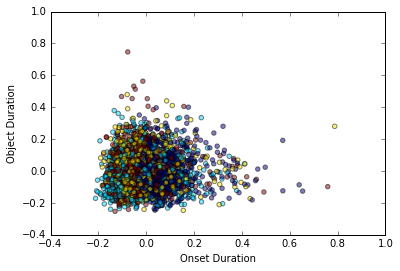

In [18]:
plt.scatter(X[:,0],X[:,1],c = y, alpha = .5)
plt.xlabel("Onset Duration")
plt.ylabel("Object Duration")

On to the actual model. In a future version, this will be fit with training data only. Once we have the model, we want several things: a visualization of its predictions, a visualization of the regions, and an accuracy score. The code after the fitting line below accomplishes the first two, by creating a "mesh" of the predictions, and then overlaying the observed categories. Because that was the hardest part for me of getting this to work, I'm including some more-detailed comments in the code block.

In [8]:
cluster.fit(feat_col,y)

LinearSVC(C=1.0, class_weight=None, dual=False, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

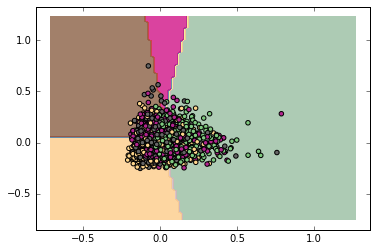

In [23]:
# This defines a range for the plot - slightly bigger than the highest
# and lowest values present in the data.
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5

# This function is ridiculous. It produces two square matrices of the same
# dimensionality, namely as many steps as there are between the min
# and max values (in this case 100x100). This lets you cover the range of
# values in each of the matrices and pair up appropriate x and y coordinates.
# Here, it's going to get used to generate an appropriately-sized plot,
# including the predictions made by the SVC at each combination of points
# along the dimensions.
xx, yy = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02))

# The prediction is obvious. np.c_ and .ravel() perform transformations
# that make it possible to feed the appropriate matrices into the predict
# function and produce the correctly-dimensioned Z matrix. Ravel spits
# out a 1-d object, and then c_ stacks the two of those objects column-wise
# so that predict gets the correct input.
Z = cluster.predict(np.c_[xx.ravel(), yy.ravel()])

# And then we want to make sure that the Z matrix is in the correct shape
# so that it corresponds with the x and y coordinates that we're plotting
Z = Z.reshape(xx.shape)

# Finally, we plot the predicted values for the dense coordinate map we
# generated (top plotting function), and then overlay the actual categories
# (bottom plotting function)
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
plt.scatter(X[:,0],X[:,1], c = y, cmap = plt.cm.Accent)

As you can see, the fit is terrible. If one were being charitable, one could say that it has the general positions of brown, light-brown, and green approximately, vaguely correct. Many of the green points are on the middle-right of the graph, and most of the brown points of either shade are nearer the left. Pink, however, is entirely wrong, and hilariously so.

I think the biggest problem here is the inflexibility of the fitting parameter(s) I gave the original SVC. A linear kernel clearly isn't appropriate here, because it only allows for linear divisions among the categories. These data points are clustered far too tightly, and in many ways circularly, for a linear kernel to achieve high accuracy. However, if you look at sheer accuracy, the categorizer does better than chance. Still, there is a lot of room for improvement.

In [26]:
cluster.score(X,y)

0.4152479644707624

In [70]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(solver = 'lsqr')
scores = cross_validation.cross_val_score(lda,X,y,cv = 45)
scores.mean()

0.32354896746370276

In [73]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
scores = cross_validation.cross_val_score(qda,X,y,cv = 45)
scores.mean()

0.32155017334484137

In [84]:
qda.fit(X_train,y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4]


TypeError: Input z must be a 2D array.

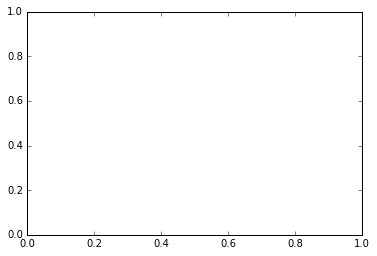

In [85]:
# This defines a range for the plot - slightly bigger than the highest
# and lowest values present in the data.
x_min, x_max = X_test[:, 0].min() - .5, X_test[:, 0].max() + .5
y_min, y_max = X_test[:, 1].min() - .5, X_test[:, 1].max() + .5
z_min, z_max = X_test[:, 2].min() - .5, X_test[:, 2].max() + .5

# This function is ridiculous. It produces two square matrices of the same
# dimensionality, namely as many steps as there are between the min
# and max values (in this case 100x100). This lets you cover the range of
# values in each of the matrices and pair up appropriate x and y coordinates.
# Here, it's going to get used to generate an appropriately-sized plot,
# including the predictions made by the SVC at each combination of points
# along the dimensions.
xx, yy, zz = np.meshgrid(np.arange(x_min, x_max, .02),
                     np.arange(y_min, y_max, .02),
                        np.arange(z_min, z_max, .02))


# The prediction is obvious. np.c_ and .ravel() perform transformations
# that make it possible to feed the appropriate matrices into the predict
# function and produce the correctly-dimensioned Z matrix. Ravel spits
# out a 1-d object, and then c_ stacks the two of those objects column-wise
# so that predict gets the correct input.
Z = qda.predict(np.c_[xx.ravel(),yy.ravel(),zz.ravel()])

# And then we want to make sure that the Z matrix is in the correct shape
# so that it corresponds with the x and y coordinates that we're plotting
print(Z[50:100])

# Finally, we plot the predicted values for the dense coordinate map we
# generated (top plotting function), and then overlay the actual categories
# (bottom plotting function)
plt.contourf(xx, yy, Z, cmap=plt.cm.Accent, alpha=0.8)
plt.scatter(X_test[:,0],X_test[:,1], c = y_test, cmap = plt.cm.Accent)

In [60]:
345*501

172845

In [101]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(exp.exp[1]['condition'][1:30])
le.transform(exp.exp[1]['condition'][1:30]) + 1

array([2, 2, 2, 2, 2, 3, 2, 3, 4, 1, 2, 2, 2, 3, 2, 2, 2, 2, 4, 4, 2, 4, 2,
       3, 1, 4, 1, 1, 3], dtype=int64)

In [99]:
exp.exp[1]['condition_num'][1:30]

1     2
2     2
3     2
4     2
5     2
6     3
7     2
8     3
9     4
10    1
11    2
12    2
13    2
14    3
15    2
16    2
17    2
18    2
19    4
20    4
21    2
22    4
23    2
24    3
25    1
26    4
27    1
28    1
29    3
Name: condition_num, dtype: int64